# Exploratory Data Analysis

In [1]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import altair as alt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

In [2]:
df = pd.read_csv('video titles dataset.csv')
df.head()

,Unnamed: 0,Title,Topic
0,0,Types of sets,Sets
1,1,CBSE Class 2 Maths | CBSE Maths Chapter 5 - Pa...,Symmetry
2,2,Why Do We Fart? - The Dr. Binocs Show | Best L...,Operations of Whole Number
3,3,Lesson 12. Triangles and Quadrilaterals | Math...,Number Patterns
4,4,"Triangular Numbers 1, 3, 6, 10, 15 Non-Linear ...",Number Patterns


In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
# check columns
df.columns

Index(['Title', 'Topic'], dtype='object')

In [5]:
# check for missing values in any column
df.isnull().any()

Title     True
Topic    False
dtype: bool

In [6]:
print(f'Dataset shape = {df.shape}')

Dataset shape = (1174, 2)


In [7]:
# Drop null values
df.dropna(inplace=True)

In [8]:
print(f'Dataset shape = {df.shape}')

Dataset shape = (1172, 2)


### Number of titles in each topic

In [9]:
bars = alt.Chart(df).mark_bar(size=50).encode(
    x=alt.X("Topic"),
    y=alt.Y("count():Q", axis=alt.Axis(title='Number of titles')),
    tooltip=[alt.Tooltip('count()', title='Number of titles'), 'Topic'],
    color='Topic'

)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='count()'
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "Number of titles in each category",
)

alt.LayerChart(...)

### % of transcripts in each topic

In [10]:
df['id'] = 1
df2 = pd.DataFrame(df.groupby('Topic').count()['id']).reset_index()

bars = alt.Chart(df2).mark_bar(size=50).encode(
    x=alt.X('Topic'),
    y=alt.Y('PercentOfTotal:Q', axis=alt.Axis(format='.0%', title='% of Titles')),
    color='Topic'
).transform_window(
    TotalArticles='sum(id)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.id / datum.TotalArticles"
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    #dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('PercentOfTotal:Q', format='.1%')
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "% of titles in each topic",
)

alt.LayerChart(...)

<b>The classes are approximately balanced.So, no need to oversampling or undersampling to balance the classes<b/>

### News length by topic

In [11]:
df.drop('id',axis=1,inplace=True)
df['Title Length'] = df['Title'].str.len()
df.head()

,Title,Topic,Title Length
0,Types of sets,Sets,13
1,CBSE Class 2 Maths | CBSE Maths Chapter 5 - Pa...,Symmetry,96
2,Why Do We Fart? - The Dr. Binocs Show | Best L...,Operations of Whole Number,85
3,Lesson 12. Triangles and Quadrilaterals | Math...,Number Patterns,68
4,"Triangular Numbers 1, 3, 6, 10, 15 Non-Linear ...",Number Patterns,59


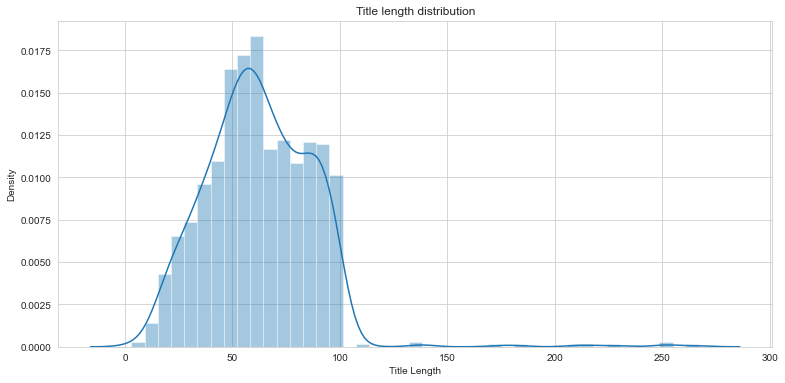

In [12]:
plt.figure(figsize=(12.8,6))
sns.distplot(df['Title Length']).set_title('Title length distribution');

<b> Take 95% percentiles to remove skewness. Then, it will be easy for training the model</b> 

In [13]:
quantile_95 = df['Title Length'].quantile(0.95)
df_1 = df[df['Title Length'] < quantile_95]
df_1.head()

,Title,Topic,Title Length
0,Types of sets,Sets,13
1,CBSE Class 2 Maths | CBSE Maths Chapter 5 - Pa...,Symmetry,96
2,Why Do We Fart? - The Dr. Binocs Show | Best L...,Operations of Whole Number,85
3,Lesson 12. Triangles and Quadrilaterals | Math...,Number Patterns,68
4,"Triangular Numbers 1, 3, 6, 10, 15 Non-Linear ...",Number Patterns,59


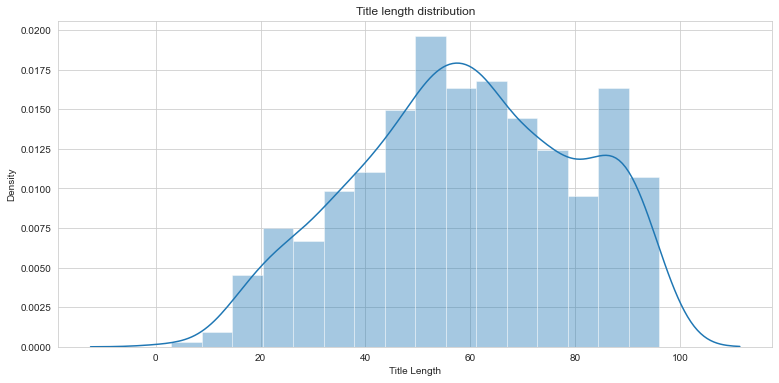

In [14]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_1['Title Length']).set_title('Title length distribution');

# Feature Engineering

The next step is to create features from the raw text so we can train the machine learning models. The steps followed are:

1. **Text Cleaning and Preparation**: cleaning of special characters, downcasing, punctuation signs. possessive pronouns and stop words removal and lemmatization. 
2. **Label coding**: creation of a dictionary to map each category to a code.
3. **Train-test split**: to test the models on unseen data.
4. **Text representation**: use of TF-IDF scores to represent text.

## 1. Text cleaning and preparation

### 1.1. Replace \n and \t

In [15]:
df_1['Title Parsed'] = df_1['Title'].str.replace("\r", " ")
df_1['Title Parsed'] = df_1['Title Parsed'].str.replace("\n", " ")

### 1.2. Convert to lowercase

In [16]:
df_1['Title Parsed'] = df_1['Title Parsed'].str.lower()

### 1.3. Remove punctuation signs

In [17]:
punctuation_signs = list("?:!.,;-$&^*%(){}[]/><@#~`|+_=“”…’−‘")
for punct_sign in punctuation_signs:
    df_1['Title Parsed'] = df_1['Title Parsed'].str.replace(punct_sign, '')

### 1.4. Remove possessive pronouns

In [18]:
df_1['Title Parsed'] = df_1['Title Parsed'].str.replace("'s", "")

### 1.5. Remove numbers

In [19]:
digits = list("1234567890")
for digit in digits:
    df_1['Title Parsed'] = df_1['Title Parsed'].str.replace(digit, '')

### 1.6. Remove single quote and double quote

In [20]:
df_1['Title Parsed'] = df_1['Title Parsed'].str.replace("'", "")
df_1['Title Parsed'] = df_1['Title Parsed'].str.replace('"', '')

### 1.7 Lemmatization

In [21]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

------------------------------------------------------------


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ameshmjayaweera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ameshmjayaweera/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [23]:
nrows = len(df_1)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df_1.iloc[row]['Title Parsed']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [24]:
df_1['Title Parsed'] = lemmatized_text_list

### 1.8. Remove Stop words

In [25]:
# Downloading the stop words list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ameshmjayaweera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
# Loading the stop words in english
stop_words = list(stopwords.words('english'))

In [27]:
# remove stop words
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df_1['Title Parsed'] = df_1['Title Parsed'].str.replace(regex_stopword, '')

### 1.9 Remove extra spaces

In [28]:
df_1['Title Parsed'] = df_1['Title Parsed'].str.split()

In [29]:
df_1['Title Parsed'] = df_1['Title Parsed'].str.join(" ")

In [30]:
# check for missing values in any column
df_1.isnull().any()

Title           False
Topic           False
Title Length    False
Title Parsed    False
dtype: bool

### 1.10 Common Words

In [31]:
topics = list(df_1['Topic'].unique())
print(f'{topics}')

['Sets', 'Symmetry', 'Operations of Whole Number', 'Number Patterns', 'Factors and Multiplication', 'Algebra Expression', 'Directed Numbers', 'Indices', 'Angles', 'Perimeter']


In [32]:
topics_as_dict = dict()
for topic in topics:
    sentences_as_set = set()
    sentences = df_1[df_1['Topic'] == topic]['Title Parsed'].to_list()
    for sent in sentences:
        sentences_as_set.update(set(sent.split()))
    topics_as_dict[topic] = sentences_as_set

In [33]:
# find common words between all topics
common_words = topics_as_dict['Directed Numbers']
for topic,words_set in topics_as_dict.items():
    if topic == 'Directed Numbers':
        continue
    common_words = common_words.intersection(words_set)
    
print(f'Size of common words = {len(common_words)}')

Size of common words = 18


In [34]:
common_words

{'academy',
 'antic',
 'cbse',
 'chapter',
 'class',
 'grade',
 'introduction',
 'khan',
 'learn',
 'lesson',
 'math',
 'mathematics',
 'maths',
 'number',
 'part',
 'periwinkle',
 'school',
 'th'}

In [35]:
common_words_file = open('common words - title.txt','w+')
for common_word in common_words:
    common_words_file.write(f'{common_word}\n')
common_words_file.close()

In [36]:
size = len(df_1)
print(size)

1105


In [37]:
df_1.reset_index(inplace=True)
df_1.shape

(1105, 5)

In [38]:
df_1.drop('index',axis=1,inplace=True)

In [39]:
df_1.head()

,Title,Topic,Title Length,Title Parsed
0,Types of sets,Sets,13,type set
1,CBSE Class 2 Maths | CBSE Maths Chapter 5 - Pa...,Symmetry,96,cbse class maths cbse maths chapter pattern nc...
2,Why Do We Fart? - The Dr. Binocs Show | Best L...,Operations of Whole Number,85,fart dr binocs show best learn videos kid peek...
3,Lesson 12. Triangles and Quadrilaterals | Math...,Number Patterns,68,lesson triangles quadrilaterals maths session ...
4,"Triangular Numbers 1, 3, 6, 10, 15 Non-Linear ...",Number Patterns,59,triangular number nonlinear pattern rule


In [40]:
df_1.tail()

,Title,Topic,Title Length,Title Parsed
1100,Introduction to Sets for Roster Method & Set B...,Sets,86,introduction set roster method set builder for...
1101,Symmetry | Rotational Symmetry | Class 6,Symmetry,40,symmetry rotational symmetry class
1102,Fractions - Lowest Terms | Mathematics Grade 4...,Angles,59,fraction lowest term mathematics grade periwinkle
1103,Math Antics - Ratios And Rates,Angles,30,math antic ratios rat
1104,Lesson 1. Circles | Maths Session for Grade 06,Indices,46,lesson circle maths session grade


In [41]:
# remove all common words
for index in range(size):
    df_1.loc[index,'Title Parsed'] = " ".join(list(set(df_1.loc[index]['Title Parsed'].split()).difference(common_words)))

In [42]:
df_1['Title Parsed Length'] = df_1['Title Parsed'].str.len()

In [43]:
df_1.head()

,Title,Topic,Title Length,Title Parsed,Title Parsed Length
0,Types of sets,Sets,13,set type,8
1,CBSE Class 2 Maths | CBSE Maths Chapter 5 - Pa...,Symmetry,96,syllabus ncert pattern,22
2,Why Do We Fart? - The Dr. Binocs Show | Best L...,Operations of Whole Number,85,dr peekaboo kid binocs kidz fart best show videos,49
3,Lesson 12. Triangles and Quadrilaterals | Math...,Number Patterns,68,triangles quadrilaterals session,32
4,"Triangular Numbers 1, 3, 6, 10, 15 Non-Linear ...",Number Patterns,59,nonlinear pattern triangular rule,33


In [44]:
# check for missing values in any column
df_1.isnull().any()

Title                  False
Topic                  False
Title Length           False
Title Parsed           False
Title Parsed Length    False
dtype: bool

In [45]:
df_1.shape

(1105, 5)

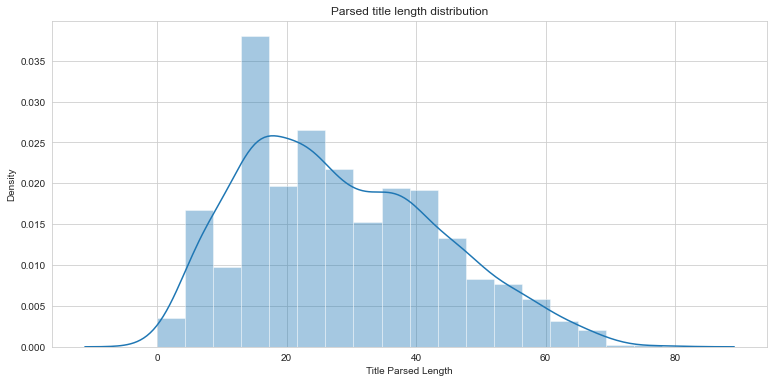

In [46]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_1['Title Parsed Length']).set_title('Parsed title length distribution');

### 1.11 Make Vocabulary with High Frequency Words

In [47]:
all_words = list()
words_list = df_1['Title Parsed'].str.split().to_list()
for words in words_list:
    all_words.extend(words)

In [48]:
word_freq = dict()

for word in all_words:
    if word not in word_freq:
        word_freq[word] = 0
    word_freq[word] += 1
    
print(f'Size = {len(word_freq)}')

Size = 784


In [49]:
sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: -item[1]))

In [50]:
number_of_words_less_than_threshold_5 = 0
less_freq_words = list()
vocaubulary = list()
for word, freq in sorted_word_freq.items():
    if freq < 5:
        number_of_words_less_than_threshold_5 += 1
        less_freq_words.append(word)
    else:
        vocaubulary.append(word)
        
print(f'Number of words less than threshold 5 = {number_of_words_less_than_threshold_5}')

Number of words less than threshold 5 = 579


<b> take words only more than or equal 2 occurences </b>

In [51]:
vocaubulary = set(vocaubulary)
print(f'Vocaubulary size = {len(vocaubulary)}')

vocaubulary_file = open('vocaubulary - titles.txt','w+')
for word in vocaubulary:
    vocaubulary_file.write(f'{word}\n')
vocaubulary_file.close()

Vocaubulary size = 205


In [52]:
vocaubulary_list = list(vocaubulary)

In [53]:
size = len(df_1)

In [54]:
# remove all common words
for index in range(size):
    df_1.loc[index,'Title Parsed'] = " ".join(list(set(df_1.loc[index]['Title Parsed'].split()).intersection(vocaubulary_list)))

In [55]:
df_1.head()

,Title,Topic,Title Length,Title Parsed,Title Parsed Length
0,Types of sets,Sets,13,set type,8
1,CBSE Class 2 Maths | CBSE Maths Chapter 5 - Pa...,Symmetry,96,syllabus ncert pattern,22
2,Why Do We Fart? - The Dr. Binocs Show | Best L...,Operations of Whole Number,85,kid videos,49
3,Lesson 12. Triangles and Quadrilaterals | Math...,Number Patterns,68,triangles session,32
4,"Triangular Numbers 1, 3, 6, 10, 15 Non-Linear ...",Number Patterns,59,pattern rule,33


In [56]:
df_1['Title Parsed Length'] = df_1['Title Parsed'].str.len()

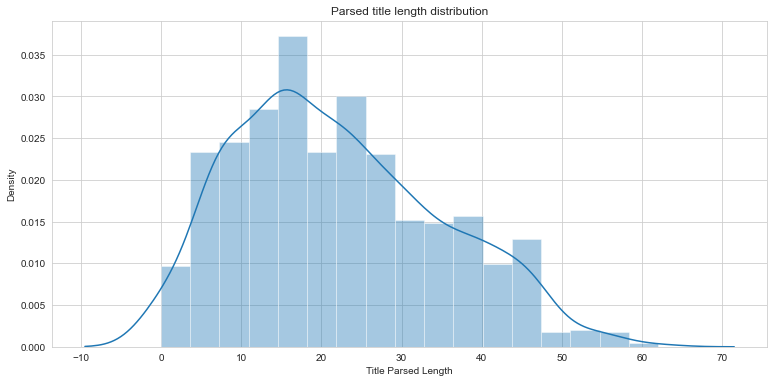

In [57]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_1['Title Parsed Length']).set_title('Parsed title length distribution');

In [58]:
# check for missing values in any column
df_1.isnull().any()

Title                  False
Topic                  False
Title Length           False
Title Parsed           False
Title Parsed Length    False
dtype: bool

In [59]:
# check if any data point contains parsed length as zero
df_1[df_1['Title Parsed Length'] == 0]

,Title,Topic,Title Length,Title Parsed,Title Parsed Length
19,ore and After Numbers | Mathematics Grade 1 | ...,Directed Numbers,56,,0
33,Learning Even And Odd Numbers | Mathematics Gr...,Number Patterns,64,,0
35,Class 5 || Maths || Are,Angles,23,,0
39,Class 5 || CBSE || Maths || Let us start learn...,Symmetry,78,,0
77,10 Fun Kiddy Riddles That Stump Most Adults,Number Patterns,43,,0
85,Roman Numerals | Mathematics Grade 5 | Periwinkle,Operations of Whole Number,49,,0
92,Class 5 || CBSE || Maths || Let us start learn...,Perimeter,78,,0
129,GCF,Factors and Multiplication,3,,0
162,Refraction of Ligh,Angles,18,,0
180,Writing Roman Numerals | Mathematics Grade 3 |...,Directed Numbers,57,,0


In [60]:
df_1 = df_1[df_1['Title Parsed Length'] != 0]
df_1.shape

(1070, 5)

## 2. Label coding

In [61]:
topic_codes = dict()
index = 0
for topic in list(df_1['Topic'].unique()):
    topic_codes[topic] = index
    index += 1

In [62]:
topic_codes

{'Sets': 0,
 'Symmetry': 1,
 'Operations of Whole Number': 2,
 'Number Patterns': 3,
 'Factors and Multiplication': 4,
 'Algebra Expression': 5,
 'Directed Numbers': 6,
 'Indices': 7,
 'Angles': 8,
 'Perimeter': 9}

In [63]:
df_1['Topic Codes'] = df_1['Topic']
df_1 = df_1.replace({'Topic Codes' : topic_codes})
#df_1.drop('index',axis=1,inplace=True)
df_1.head()

,Title,Topic,Title Length,Title Parsed,Title Parsed Length,Topic Codes
0,Types of sets,Sets,13,set type,8,0
1,CBSE Class 2 Maths | CBSE Maths Chapter 5 - Pa...,Symmetry,96,syllabus ncert pattern,22,1
2,Why Do We Fart? - The Dr. Binocs Show | Best L...,Operations of Whole Number,85,kid videos,10,2
3,Lesson 12. Triangles and Quadrilaterals | Math...,Number Patterns,68,triangles session,17,3
4,"Triangular Numbers 1, 3, 6, 10, 15 Non-Linear ...",Number Patterns,59,pattern rule,12,3


In [64]:
# save pre-processed dataset
df_1.to_csv(r'pre-processed video titles dataset.csv', sep=',', encoding='utf-8', header='true')

In [65]:
# check for missing values in any column
df_1.isnull().any()

Title                  False
Topic                  False
Title Length           False
Title Parsed           False
Title Parsed Length    False
Topic Codes            False
dtype: bool

In [66]:
# load pre-processed dataset
df_2 = pd.read_csv('pre-processed video titles dataset.csv')
df_2.head()

,Unnamed: 0,Title,Topic,Title Length,Title Parsed,Title Parsed Length,Topic Codes
0,0,Types of sets,Sets,13,set type,8,0
1,1,CBSE Class 2 Maths | CBSE Maths Chapter 5 - Pa...,Symmetry,96,syllabus ncert pattern,22,1
2,2,Why Do We Fart? - The Dr. Binocs Show | Best L...,Operations of Whole Number,85,kid videos,10,2
3,3,Lesson 12. Triangles and Quadrilaterals | Math...,Number Patterns,68,triangles session,17,3
4,4,"Triangular Numbers 1, 3, 6, 10, 15 Non-Linear ...",Number Patterns,59,pattern rule,12,3


In [67]:
# check for missing values in any column
df_2.isnull().any()

Unnamed: 0             False
Title                  False
Topic                  False
Title Length           False
Title Parsed           False
Title Parsed Length    False
Topic Codes            False
dtype: bool

In [68]:
# Drop null values
df_2.dropna(inplace=True)
df_2.drop('Unnamed: 0',axis=1,inplace=True)
df_2.head()

,Title,Topic,Title Length,Title Parsed,Title Parsed Length,Topic Codes
0,Types of sets,Sets,13,set type,8,0
1,CBSE Class 2 Maths | CBSE Maths Chapter 5 - Pa...,Symmetry,96,syllabus ncert pattern,22,1
2,Why Do We Fart? - The Dr. Binocs Show | Best L...,Operations of Whole Number,85,kid videos,10,2
3,Lesson 12. Triangles and Quadrilaterals | Math...,Number Patterns,68,triangles session,17,3
4,"Triangular Numbers 1, 3, 6, 10, 15 Non-Linear ...",Number Patterns,59,pattern rule,12,3


In [69]:
# check for missing values in any column
df_2.isnull().any()

Title                  False
Topic                  False
Title Length           False
Title Parsed           False
Title Parsed Length    False
Topic Codes            False
dtype: bool

In [70]:
df_2.shape

(1070, 6)

## 3. Train - test split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df_2['Title Parsed'], 
                                                    df_2['Topic Codes'], 
                                                    test_size = 0.15, 
                                                    random_state = 8)

In [72]:
print(f'X_train shape = {X_train.shape}, X_test shape = {X_test.shape}, y_train shape = {y_train.shape}, y_test shape = {y_test.shape}')

X_train shape = (909,), X_test shape = (161,), y_train shape = (909,), y_test shape = (161,)


In [73]:
X_train.head()

18     subtract simple integers add use
540      whole dont memorise properties
682      positive negative add integers
629                        study series
64                           ncert data
Name: Title Parsed, dtype: object

In [74]:
y_train.head()

18     6
540    2
682    6
629    7
64     8
Name: Topic Codes, dtype: int64

In [75]:
# check for missing values in any column
X_train.isnull().any()

False

In [76]:
y_train.shape

(909,)

In [77]:
X_train.shape

(909,)

In [78]:
X_test.shape

(161,)

In [79]:
y_test.shape

(161,)

## 4. Text representation

We have various options:

* Count Vectors as features
* TF-IDF Vectors as features
* Word Embeddings as features
* Text / NLP based features
* Topic Models as features

We'll use **Count Vectors** as features.

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(X_train)
labels_train = y_train
print(features_train.shape)

features_test = vectorizer.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(909, 203)
(161, 203)


In [81]:
# X_train
with open('Pickles - Title/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('Pickles - Title/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('Pickles - Title/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('Pickles - Title/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('Pickles - Title/df_2.pickle', 'wb') as output:
    pickle.dump(df_2, output)
    
# features_train
with open('Pickles - Title/features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('Pickles - Title/labels_train.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('Pickles - Title/features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('Pickles - Title/labels_test.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
# Count Vectorizer object
with open('Pickles - Title/vectorizer.pickle', 'wb') as output:
    pickle.dump(vectorizer, output)